# Calculate heatwave occurrances 

## Heatwave definition

Heatwaves are now defined as:

Tmin > 95percentile AND Tmax > 95percentile

For more than 2 consecutive days (i.e. total of 3 or more days).

This replaces the definition of only Tmin > 99percentile for more than 3 consecutive days (total of 4 or more days).

This is what is requested from the Lancet. To be honest it's not clear whether this produces a substantially 'better' indicator since all heatwave indicators are arbitrary in absence of covariate data (i.e. impact data). Furthermore we know that the health impacts are mediated by many other things, so in any case we are truely interested just in the trends i.e. demonstrating that there is a) more heatwaves and b) more exposure to heatwaves - this can be followed by local studies but (as always) the point is to present a general risk factor trend.


In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from scipy import stats

from tqdm.notebook import tqdm, tnrange
from dask.diagnostics import ProgressBar
from joblib import Parallel, delayed

from config import DATA_SRC, WEATHER_SRC

import heatwave_indices


xr.set_options(keep_attrs=True)

# Figure settings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (5,2.5)
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['savefig.bbox'] = 'tight'

In [2]:
MAP_PROJECTION = ccrs.EckertIII()

### Setup Paths

> NOTE: considered just adding the newest year each time instead of re-calculating the whole thing. HOWEVER in reality, the input data is still changing year to year, so far have needed to re-calculate anyway (e.g. change in resolution, change from ERAI to ERA5, in the future probably use ERA5-Land, etc). Although it seems like a cool idea to have a reproducible method where each year you just add one thing, in practice its better to have one 'frozen' output corresponding to each publication, so that it's easy to go back later to find data corresponding to specific results. Additionally, generating one file per year means you have a folder full of files that are harder to share, and the outputs are in the end pretty small (<50MB in Float32)}.

In [5]:
#Weighting for cells
# cos_lat = np.cos(np.radians(t_min_threshold.latitude))

MAX_YEAR = 2021

REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

# TEMPERATURES_FOLDER = WEATHER_SRC / 'era5_land' / 'era5_land_daily_summary'
# CLIMATOLOGY_QUANTILES = WEATHER_SRC / 'era5_land' / 'era5_land_daily_quantiles'

TEMPERATURES_FOLDER = WEATHER_SRC / 'era5_0.25deg' / 'daily_temperature_summary'
CLIMATOLOGY_QUANTILES = WEATHER_SRC / 'era5_0.25deg' / 'daily_tas_quantiles_1986-2005.nc'


RESULTS_FOLDER = Path('../results/heatwaves/').absolute()
RESULTS_FOLDER.mkdir(exist_ok=True)

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'heatwaves'/ 'results_2022'
INTERMEDIATE_RESULTS_FOLDER.mkdir(exist_ok=True)


In [6]:
assert INTERMEDIATE_RESULTS_FOLDER.is_dir()
assert RESULTS_FOLDER.is_dir()

In [7]:
# quantiles_files = list(CLIMATOLOGY_QUANTILES.rglob('*.nc'))

In [8]:
temperature_files = [(year, TEMPERATURES_FOLDER / f'{year}_temperature_summary.nc') for year in range(1980, MAX_YEAR+1)]

## Load reference temperature quantiles

Load both the tmin and tmax quatiles and place in a list

In [11]:
QUANTILE = 0.95

# Need to use tolerance/nearest b/c of floating point drift (0.95 != 0.95)
t_min_threshold = xr.open_dataset().t_min.sel(quantile=QUANTILE, drop=True, tolerance=0.001, method='nearest')
t_max_threshold = t_quantiles.t_max.sel(quantile=QUANTILE, drop=True, tolerance=0.001, method='nearest')

t_thresholds = [t_min_threshold, t_max_threshold]

In [13]:
cos_lat = np.cos(np.radians(t_min_threshold.latitude))

# Define calculation functions for counting heatwave occurances

Apply heatwave index function to selected vars using selected threshold days

In [14]:
# def ds_for_year(year):
#     temperature_files = []
#     for folder in sorted([p for p in TEMPERATURES_FOLDER.glob('*') 
#             if int(p.name) == year
#            ]):
#         temperature_files += [p for p in folder.rglob('*.nc')]
#     ds = xr.open_mfdataset(temperature_files)
#     ds = ds.drop('time_bnds')
#     ds = ds.transpose('time','latitude','longitude')
#     return ds
    

# def apply_func_for_file(func, year, t_thresholds, t_var_names, days_threshold=2):
#     ds = ds_for_year(year)
    
#     datasets_year = [ds[name] for name in t_var_names]
#     result = func(datasets_year, t_thresholds, days_threshold)
    
#     # Add a year dimension matching the input file
#     result = result.expand_dims(dim={'year': [year]})
#     return year, result

# def apply_func_and_save(func, year, output_folder, t_thresholds,  t_var_names=['tmin', 'tmax'], 
#                         days_threshold=2, overwrite=False,
#                         filename_pattern='indicator_{year}.nc'
#                        ):
#     output_file = output_folder / filename_pattern.format(year=year)
#     if output_file.exists() is False and overwrite is False:
#         year, result = apply_func_for_file(func, year, t_thresholds, t_var_names=t_var_names, days_threshold=days_threshold)
#         result.to_netcdf(output_file)
#         return f'Created {output_file}'
#     else:
#         return f'Skipped {output_file}, already exists'

In [17]:
def ds_for_year(year):
    ds = xr.open_dataset(TEMPERATURES_FOLDER / f'{year}_temperature_summary.nc')
    ds = ds.transpose('time','latitude','longitude')
    return ds
    

def apply_func_for_file(func, year, t_thresholds, t_var_names, days_threshold=2):
    ds = ds_for_year(year)
    
    datasets_year = [ds[name] for name in t_var_names]
    result = func(datasets_year, t_thresholds, days_threshold)
    
    # Add a year dimension matching the input file
    result = result.expand_dims(dim={'year': [year]})
    return year, result

def apply_func_and_save(func, year, output_folder, t_thresholds,  t_var_names=['tmin', 'tmax'], 
                        days_threshold=2, overwrite=False,
                        filename_pattern='indicator_{year}.nc'
                       ):
    output_file = output_folder / filename_pattern.format(year=year)
    if output_file.exists() is False and overwrite is False:
        year, result = apply_func_for_file(func, year, t_thresholds, t_var_names=t_var_names, days_threshold=days_threshold)
        result.to_netcdf(output_file)
        return f'Created {output_file}'
    else:
        return f'Skipped {output_file}, already exists'

# Calculate heatwave occurances


## Multi-threshold versions


### Heatwave number of days

In [19]:
out_folder = INTERMEDIATE_RESULTS_FOLDER / 'heatwave_days_era5'

out_folder.mkdir(exist_ok=True)

# apply_func_and_save(heatwave_indices.heatwaves_counts_multi_threshold, 2000, out_folder, t_thresholds, t_var_names=['tmin', 'tmax'])

res = Parallel(n_jobs=8, verbose=2)(
    delayed(apply_func_and_save)(heatwave_indices.heatwaves_days_multi_threshold, year, out_folder, t_thresholds, ['t_min', 't_max'])
    for year, file in  temperature_files
)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done  42 out of  42 | elapsed:  4.9min finished


### Heatwave Counts

In [21]:
out_folder = INTERMEDIATE_RESULTS_FOLDER / 'heatwave_counts_era5'

out_folder.mkdir(exist_ok=True)

# apply_func_and_save(heatwave_indices.heatwaves_counts_multi_threshold, 2000, out_folder, t_thresholds, t_var_names=['tmin', 'tmax'])

res = Parallel(n_jobs=10, verbose=2)(
    delayed(apply_func_and_save)(heatwave_indices.heatwaves_counts_multi_threshold, year, out_folder, t_thresholds, ['t_min', 't_max'])
    for year, file in  temperature_files
)


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done  42 out of  42 | elapsed:  3.0min finished


### Heatwave length

In [28]:
heatwave_mean_length = heatwaves_days / heatwaves_counts

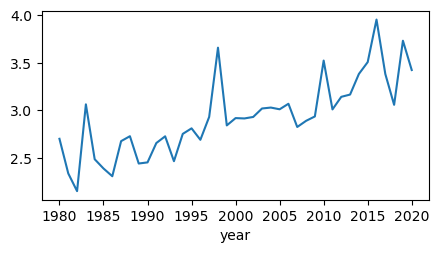

In [29]:
(heatwave_mean_length*cos_lat).mean(dim=['latitude', 'longitude']).plot()

In [30]:
(heatwave_mean_length.to_dataset(name='heatwave_mean_length')
 .to_netcdf(INTERMEDIATE_RESULTS_FOLDER / f'heatwave_mean_length_multi_threshold_1980-{MAX_YEAR}.nc',
            encoding={'heatwave_mean_length':{'dtype':'float32'}}))

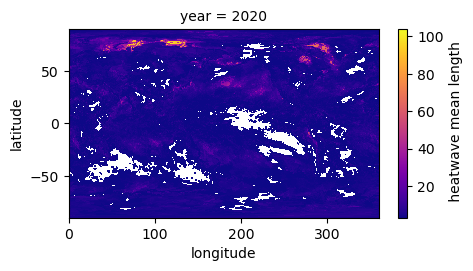

In [31]:
data = heatwave_mean_length.sel(year=MAX_YEAR)

p = data.plot.pcolormesh(
    cmap='plasma',
    cbar_kwargs={'label':' heatwave mean length'},
    robust=False
)
